# Будем предсказывать стоимость биткоина на неделю вперед

In [1]:
# tools library
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels. tsa.stattools import adfuller #Критерий Дики-Фуллера
import statsmodels.api as sm #разложение временного ряда и автокорреляция

In [2]:
# модели sklearn
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
# модели pytorch
from torch import nn

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# прогнозируемая метрика
from sklearn.metrics import mean_absolute_error as mae 

предобработка данных

In [285]:
df_train = pd.read_csv("C:\\Users\\Vitaliy\\OneDrive\\Рабочий стол\\предсказание биткоина\\bitcoin_price_Training - Training.csv", sep=',', parse_dates=True, index_col='Date')
df_train.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2017-07-31,2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
2017-07-30,2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2017-07-29,2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
2017-07-28,2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
2017-07-27,2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


In [286]:
df_train.shape

(1556, 6)

In [287]:
df2 = pd.read_csv("C:\\Users\\Vitaliy\\OneDrive\\Рабочий стол\\предсказание биткоина\\bitcoin_price_1week_Test - Test.csv", sep=',', parse_dates=True, index_col='Date')
df2.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2017-08-07,3212.78,3397.68,3180.89,3378.94,"1,482,280,000","52,987,300,000"
2017-08-06,3257.61,3293.29,3155.60,3213.94,"1,105,030,000","53,720,900,000"
2017-08-05,2897.63,3290.01,2874.83,3252.91,"1,945,700,000","47,778,200,000"
2017-08-04,2806.93,2899.33,2743.72,2895.89,"1,002,120,000","46,276,200,000"
2017-08-03,2709.56,2813.31,2685.14,2804.73,"804,797,000","44,666,400,000"


In [288]:
df = pd.concat([df_train, df2], axis=0)

In [289]:
df.index.names=['Timestamp']
df = df.sort_index()

In [290]:
df.head()

,Open,High,Low,Close,Volume,Market Cap
Timestamp,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,-,"1,500,520,000"
2013-04-29,134.44,147.49,134.00,144.54,-,"1,491,160,000"
2013-04-30,144.00,146.93,134.05,139.00,-,"1,597,780,000"
2013-05-01,139.00,139.89,107.72,116.99,-,"1,542,820,000"
2013-05-02,116.38,125.60,92.28,105.21,-,"1,292,190,000"


In [291]:
df.shape

(1563, 6)

In [292]:
def filter(x):
    if x != '-':
        return int(x.replace(',', ''))
    else:
        return np.nan

In [293]:
df.head()

,Open,High,Low,Close,Volume,Market Cap
Timestamp,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,-,"1,500,520,000"
2013-04-29,134.44,147.49,134.00,144.54,-,"1,491,160,000"
2013-04-30,144.00,146.93,134.05,139.00,-,"1,597,780,000"
2013-05-01,139.00,139.89,107.72,116.99,-,"1,542,820,000"
2013-05-02,116.38,125.60,92.28,105.21,-,"1,292,190,000"


In [294]:
for col in df.columns:
    if col == 'Volume' or col == 'Market Cap':
        df[col] = df[col].apply(lambda x: filter(x))

In [295]:
df.head()

,Open,High,Low,Close,Volume,Market Cap
Timestamp,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,NaN,1500520000
2013-04-29,134.44,147.49,134.00,144.54,NaN,1491160000
2013-04-30,144.00,146.93,134.05,139.00,NaN,1597780000
2013-05-01,139.00,139.89,107.72,116.99,NaN,1542820000
2013-05-02,116.38,125.60,92.28,105.21,NaN,1292190000


In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1563 entries, 2013-04-28 to 2017-08-07
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1563 non-null   float64
 1   High        1563 non-null   float64
 2   Low         1563 non-null   float64
 3   Close       1563 non-null   float64
 4   Volume      1320 non-null   float64
 5   Market Cap  1563 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 85.5 KB


Обработаем пропуски в данных

In [297]:
df.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume        243
Market Cap      0
dtype: int64

In [298]:
df.dropna(inplace=True)

In [299]:
df.head()

,Open,High,Low,Close,Volume,Market Cap
Timestamp,,,,,,
2013-12-27,763.28,777.51,713.60,735.07,46862700.0,9295570000
2013-12-28,737.98,747.06,705.35,727.83,32505800.0,8990850000
2013-12-29,728.05,748.61,714.44,745.05,19011300.0,8872600000
2013-12-30,741.35,766.60,740.24,756.13,20707700.0,9037000000
2013-12-31,760.32,760.58,738.17,754.01,20897300.0,9268240000


анализ временного ряда

<AxesSubplot:xlabel='Date'>

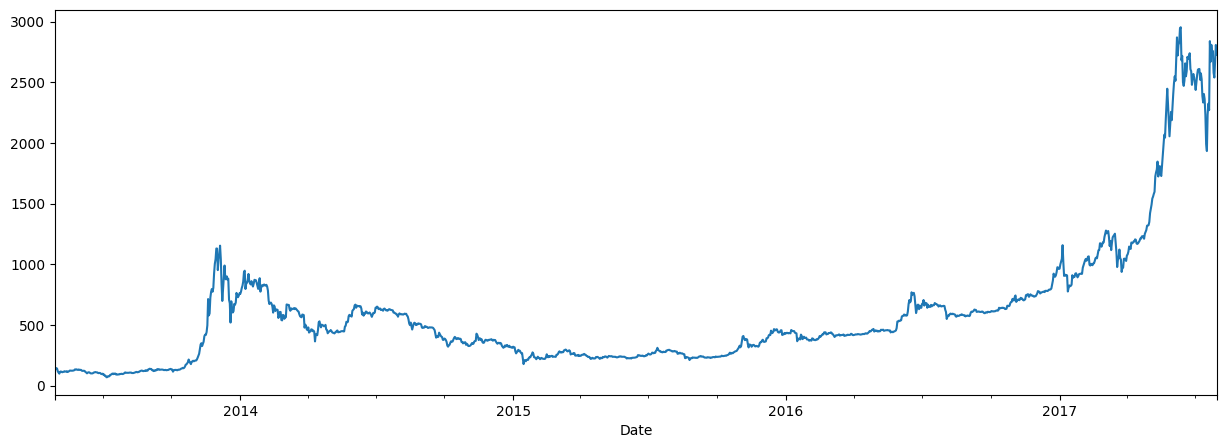

In [300]:
df_train.Open.plot()

При  помощи теста Дики-Фуллера проверяют значение коэффициента а. 
$y_{t}=a\cdot y_{{t-1}}+\varepsilon _{t}$, где $y_{t}$ — временной 
ряд, а $\varepsilon$  — ошибка.
Если a=1, то процесс имеет единичный корень, в этом случае ряд $y_{t}$ не стационарен.  Если 
|a|<1, то ряд стационарный 

In [301]:
p = adfuller(df.Open)[1]

alpha = 0.05
if p > alpha:
    print('Ряд не стационарный')
else:
    print('Ряд стационарный')

Ряд не стационарный


разложим ряд на компоненты

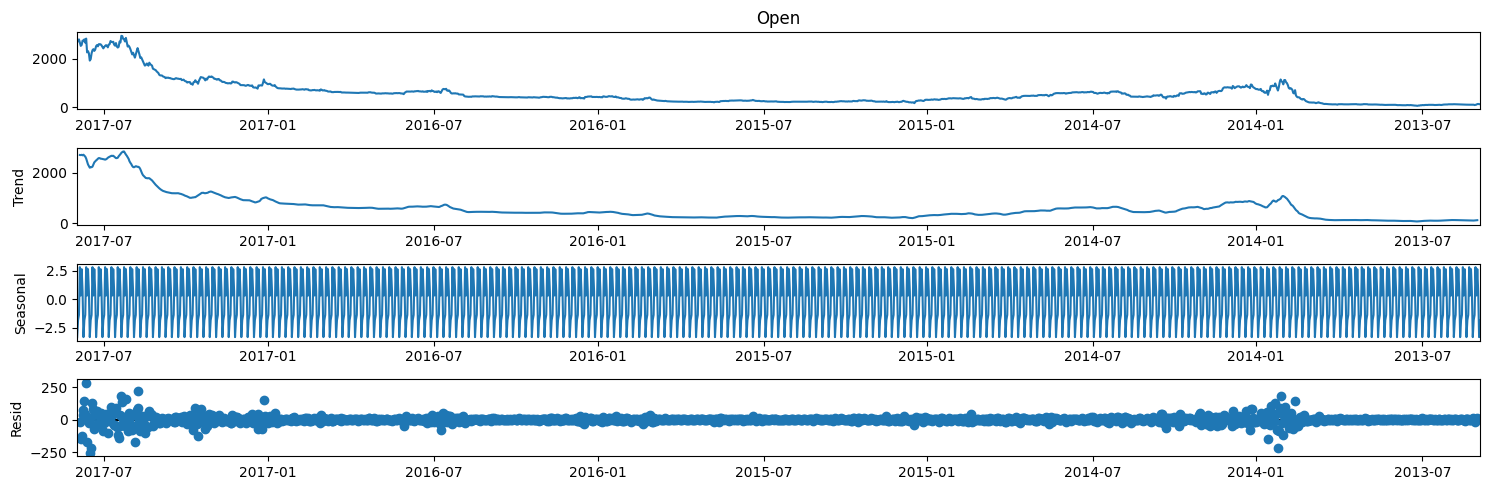

In [302]:
res = sm.tsa.seasonal_decompose(df_train.Open)
plt.rc('figure', figsize=(15,5))
resplot=res.plot()

создадим лаговые признаки и посмотрим на автокорреляцию

In [303]:
sm.tsa.acf(df.Open, nlags=50)

array([1.        , 0.9897075 , 0.97926711, 0.97102444, 0.96330853,
       0.95625161, 0.94920757, 0.9414433 , 0.93455197, 0.92766612,
       0.92042467, 0.91396383, 0.90818452, 0.90228391, 0.8954247 ,
       0.88807916, 0.88014149, 0.8723687 , 0.86334897, 0.85751814,
       0.85099277, 0.8451787 , 0.84193847, 0.8383165 , 0.83326673,
       0.82776124, 0.82206723, 0.81712478, 0.81165366, 0.80506745,
       0.79821233, 0.7912366 , 0.78319227, 0.77521905, 0.76697757,
       0.75898214, 0.75180035, 0.74544286, 0.73841577, 0.73165736,
       0.72485242, 0.71843901, 0.71208217, 0.70488071, 0.69787337,
       0.6897094 , 0.68163326, 0.67375547, 0.66553837, 0.65809479,
       0.65067964])

In [304]:
a = sm.tsa.acf(df.Open, nlags=50)

In [305]:
(a >= 0.9).sum()

14

Возьмем информацию за 14 предыдущих дней

In [306]:
for i in range(6, 20):
    df[f'lag_{i}'] = df.Open.shift(i)

df.dropna(inplace=True)

In [307]:
y, X = df.Open, df.drop(['Open'], axis=1)
X_train, X_test = X[:X.shape[0]-7], X[X.shape[0]-7:]
y_train, y_test = y[:y.shape[0]-7], y[y.shape[0]-7:]

In [308]:
models = [LinearRegression(), linear_model.Lasso(), linear_model.Ridge(), DecisionTreeRegressor(random_state=1), SVR(), GradientBoostingRegressor(), RandomForestRegressor(random_state=1)]

In [309]:
score = []
for model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score.append(mae(pred, y_test))

score = np.array(score)
print(f'Минимальный mae = {np.min(score)}\nПоказала модель {models[np.argmin(score)]}')

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e+05, tolerance: 3.749e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.53792e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Минимальный mae = 32.80572344596534
Показала модель Lasso()


In [310]:
score

array([  37.76479819,   32.80572345,   37.76470676,   94.80857143,
       2242.48499852,   93.51652416,  107.13232857])

попробуем добавить новый признак - среднюю стоимость для каждого дня, месяца

Объединим train и test и выполним преобразоание по отдельности, чтобы избежать утечки данных

In [311]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [312]:
def func(x, dt):
    return round(dt[x], 2)

In [313]:
d = dict(train.Open.groupby(train.index.day).mean())

In [314]:
for data in [train, test]:
    d = dict(data.Open.groupby(data.index.day).mean())
    m = dict(data.Open.groupby(data.index.month).mean())

    data['day'] = data.index.day
    data['month'] = data.index.month

    data.day = data.day.apply(lambda x: func(x, d))
    data.month = data.month.apply(lambda x: func(x, m))

In [315]:
y_train, X_train = train.Open, train.drop(['Open'], axis=1)
y_test, X_test = test.Open, test.drop(['Open'], axis=1)

In [316]:
X_train.head()

,High,Low,Close,Volume,Market Cap,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,day,month
Timestamp,,,,,,,,,,,,,,,,,,,,,
2014-01-15,872.81,830.86,860.90,28107200.0,10216700000,841.47,795.99,946.49,936.05,858.55,...,802.85,773.44,754.97,760.32,741.35,728.05,737.98,763.28,631.11,574.37
2014-01-16,866.16,835.63,835.63,19149300.0,10553800000,846.69,841.47,795.99,946.49,936.05,...,823.27,802.85,773.44,754.97,760.32,741.35,728.05,737.98,624.57,574.37
2014-01-17,842.91,797.63,814.64,39031700.0,10241200000,867.32,846.69,841.47,795.99,946.49,...,858.55,823.27,802.85,773.44,754.97,760.32,741.35,728.05,625.28,574.37
2014-01-18,841.49,816.07,840.00,18052700.0,10018200000,919.60,867.32,846.69,841.47,795.99,...,936.05,858.55,823.27,802.85,773.44,754.97,760.32,741.35,637.01,574.37
2014-01-19,870.96,825.53,870.96,24365700.0,10311500000,860.19,919.60,867.32,846.69,841.47,...,946.49,936.05,858.55,823.27,802.85,773.44,754.97,760.32,632.67,574.37


In [317]:
score = []
for model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score.append(mae(pred, y_test))

score = np.array(score)
print(f'Минимальный mae = {np.min(score)}\nПоказала модель {models[np.argmin(score)]}')

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e+05, tolerance: 3.749e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.50475e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Минимальный mae = 33.4115839936494
Показала модель LinearRegression()


In [318]:
score

array([  33.41158399,   43.71159247,   33.41162706,   93.75428571,
       2242.58356127,   93.36243337,  114.79      ])

качество ухудшилось, посмотрим на коэффиценеты линейной регрессии с l1 регуляризатором

In [319]:
model = linear_model.Lasso()
model.fit(X_train, y_train)
model.coef_

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e+05, tolerance: 3.749e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


array([ 7.50638439e-01,  4.00132649e-01, -4.09590969e-01, -4.72192913e-08,
        1.30105489e-08,  6.34900669e-02, -6.57028350e-02,  6.58692523e-02,
        7.61002583e-03, -2.56620465e-02,  1.24069196e-02,  5.81286005e-02,
       -1.19031052e-01,  1.71256606e-02,  2.76595687e-02, -3.06855138e-02,
        5.11201337e-02,  3.10026177e-02, -3.95252733e-02,  1.31153756e-02,
        9.05253755e-03])

Получили хуже результат. Глядя на коэффициенты линейой регрессии попробуем оставить только среднее занчение по дням

In [320]:
X_train = X_train.drop(['month'], axis=1)
X_test = X_test.drop(['month'], axis=1)

In [321]:
score = []
for model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score.append(mae(pred, y_test))

score = np.array(score)
print(f'Минимальный mae = {np.min(score)}\nПоказала модель {models[np.argmin(score)]}')

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e+05, tolerance: 3.749e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.50955e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Минимальный mae = 31.54071492303092
Показала модель Lasso()


In [322]:
score

array([  32.66800812,   31.54071492,   32.66794488,   96.94285714,
       2242.52277696,   92.4755332 ,  110.32014286])

Отлично, теперь попробуем избавиться от признака с близким к нулю весом

In [323]:
X_train = X_train.drop(['Volume'], axis=1)
X_test = X_test.drop(['Volume'], axis=1)

In [324]:
X_train2 = X_train.drop(['Market Cap'], axis=1)
X_test2 = X_test.drop(['Market Cap'], axis=1)

In [325]:
score = []
for model in models:
    model.fit(X_train2, y_train)
    pred = model.predict(X_test2)
    score.append(mae(pred, y_test))

score = np.array(score)
print(f'Минимальный mae = {np.min(score)}\nПоказала модель {models[np.argmin(score)]}')

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e+05, tolerance: 3.749e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Минимальный mae = 41.68065714966094
Показала модель Ridge()


Оказалось немного хуже

Попробоуем экспоненциальное сглаживание

In [229]:
from statsmodels.tsa.api import ExponentialSmoothing,  Holt

двойное экспоненциальное сглаживание

In [261]:
model = Holt(y_train, initialization_method='estimated').fit(smoothing_level = 0.8, smoothing_trend=0.3)
pred = model.forecast(7)
mae(pred, y_test)

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


147.51276808665793

тройное экспоненциальное сглаживание

In [264]:
model = ExponentialSmoothing(y_train,  trend='mul', seasonal='add',  initialization_method='estimated').fit()
pred = model.forecast(7)
mae(pred, y_test)

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


154.15849935932542

тройное экспоненциальное сглаживание с затухающим трендом

In [267]:
model = ExponentialSmoothing(y_train, damped_trend=True, trend='mul', seasonal='add',  initialization_method='estimated').fit()
pred = model.forecast(7)
mae(pred, y_test)

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


160.1357312946146

попробуем нейросети

In [5]:
import torch

In [6]:
data = pd.read_csv("C:\\Users\\Vitaliy\\OneDrive\\Рабочий стол\\предсказание биткоина\\bitcoin_price_Training - Training.csv", sep=',', parse_dates=True, index_col='Date')
data = data.Open.sort_index()
data

Date
2013-04-28     135.30
2013-04-29     134.44
2013-04-30     144.00
2013-05-01     139.00
2013-05-02     116.38
               ...   
2017-07-27    2538.71
2017-07-28    2679.73
2017-07-29    2807.02
2017-07-30    2724.39
2017-07-31    2763.24
Name: Open, Length: 1556, dtype: float64

In [7]:
data2 = pd.read_csv("C:\\Users\\Vitaliy\\OneDrive\\Рабочий стол\\предсказание биткоина\\bitcoin_price_1week_Test - Test.csv", sep=',', parse_dates=True, index_col='Date')
data2 = data2.Open.sort_index()
data2

Date
2017-08-01    2871.30
2017-08-02    2727.13
2017-08-03    2709.56
2017-08-04    2806.93
2017-08-05    2897.63
2017-08-06    3257.61
2017-08-07    3212.78
Name: Open, dtype: float64

In [8]:
data = pd.concat([data, data2], axis=0)
data = torch.FloatTensor(data)

In [9]:
data.shape

torch.Size([1563])

In [10]:
train = []
lag = 14
pred = 7
for i in range(lag, len(data)-pred):
    train.append(tuple([data[i-lag:i], data[i+pred-1]]))

In [11]:
test = train[len(train)-7:]
train = train[:len(train)-7]

определим модель, будем использовать рекуррентную сеть LSTM

![title](1.png)

In [17]:
class Model(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()

        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.h0 = (torch.Tensor(np.random.normal(0, 1, (1,1,self.hidden_layer_size))), torch.Tensor(np.random.normal(0, 1, (1,1,self.hidden_layer_size))))
        self.relu = nn.ReLU()

    def forward(self, inp):
        out, _ = self.lstm(inp.view(len(inp), 1, 1), self.h0)
        pred = self.linear(self.relu(out))
        return pred[-1]


In [19]:
model = Model()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1)

In [20]:
epochs = 3
model.train()

for i in range(epochs):
    loss_epoch = []
    preds = []
    labels_mas = []
    for seq, labels in train:
        optimizer.zero_grad()

        y_pred = model(seq)
        
        loss = loss_function(y_pred, labels)

        labels_mas.append(labels.item())
        loss_epoch.append((loss.item())**(1/2))
        preds.append(y_pred.item())

        loss.backward()
        optimizer.step()


c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [36]:
mas = []
model.eval()

with torch.no_grad():
    for seq, lab in test:
        pred = model(seq)
        mas.append(pred)

In [39]:
lbs = [lab for seq, lab in test]
mae(mas, lbs)

c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:746: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  array = np.asarray(array, order=order, dtype=dtype)
c:\Users\Vitaliy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np

450.47921316964283